# Data Prep & Modeling
## Filtering

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

marte_raw = pd.read_csv('marte_vs_nlwest_19_22.csv',
                        usecols=['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'zone', 'des', 'p_throws', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name', 'spin_axis'])

# rename the primary response variable
marte_raw.rename(columns={'estimated_woba_using_speedangle': 'xwOBA'}, inplace=True)
print(f"data-set shape prior to filtering: {marte_raw.shape}")

# filter sacrifice events; if woba_denom is NaN, then sacrifice event
marte_raw.dropna(axis='rows', subset=['woba_denom'], how='any', inplace=True)
print(f"data-set shape after to filtering sac hits: {marte_raw.shape}")

# filter missing observation data
marte_raw.dropna(axis='rows', subset=['release_spin_rate', 'spin_axis'], how='any', inplace=True)
print(f"data-set shape after to filtering missing spin observations: {marte_raw.shape}")

data-set shape prior to filtering: (867, 30)
data-set shape after to filtering sac hits: (865, 30)
data-set shape after to filtering missing spin observations: (859, 30)


- release_speed
    - Pitch velocities from 2008-16 are via Pitch F/X, and adjusted to roughly out-of-hand release point. All velocities from 2017 and beyond are Statcast, which are reported out-of-hand.
- release_pos_x
    - horizontal Release Position of the ball measured in feet from the catcher's perspective.
- release_pos_z
    - Vertical Release Position of the ball measured in feet from the catcher's perspective.
- plate_x
    - Horizontal position of the ball when it crosses home plate from the catcher's perspective.
- plate_z
    - Vertical position of the ball when it crosses home plate from the catcher's perspective.
- pitcher
    - MLB Player Id tied to the play event.
- zone
    - Zone location of the ball when it crosses the plate from the catcher's perspective.
- pfx_x
    - Horizontal movement in feet from the catcher's perspective.
- pfx_z
    - Vertical movement in feet from the catcher's perpsective.
- effective_speed
    - Derived speed based on the the extension of the pitcher's release.
- release_spin
    - Spin rate of pitch tracked by Statcast.
- spin_axis
    - The Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball

## Filtering ext., Computed Features, NaN Conversions

In [2]:
import numpy as np
import math

# filter raw set with proposed model metrics
marte_vs = marte_raw.drop(columns=['game_date', 'release_pos_x', 'release_pos_z', 'des', 'bb_type', 'balls', 'strikes', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_extension', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name'])
print(f"new data-set shape after to filtering for proper metrics: {marte_vs.shape}")

# vectorize the horizontal & vertical movement using pythagorean theorem
marte_vs['pfx_v'] = np.sqrt(marte_vs.pfx_x ** 2 + marte_vs.pfx_z ** 2)

print(f"number of NaN xwOBA PAs prior to conversion: {marte_vs.xwOBA.isnull().sum()}")

# convert xwOBA stat to 0.0 for strikeouts
# if the xwOBA stat is NaN & a strikeout, then need to use the woba_value

marte_vs['xwOBA'] = marte_vs.apply(lambda x: x.woba_value if (math.isnan(x.xwOBA) and x.woba_value == 0.0) else x.xwOBA, axis=1)

# filter out walks, dropped 54 walks
marte_vs.dropna(axis='rows', subset=['xwOBA'], how='any', inplace=True)
print(f"data-set shape after to filtering walks: {marte_vs.shape}")

# reorder columns for logical readability
marte_vs = marte_vs.reindex(columns=['xwOBA', 'woba_value','game_year', 'pitcher', 'p_throws', 'pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis', 'zone', 'pfx_x', 'pfx_z', 'pfx_v'])

print(marte_vs.head())

new data-set shape after to filtering for proper metrics: (859, 12)
number of NaN xwOBA PAs prior to conversion: 184
data-set shape after to filtering walks: (805, 13)
   xwOBA  woba_value  game_year  pitcher p_throws pitch_type  release_speed  \
0  0.709         0.9       2022   596001        R         SI           92.9   
1  0.262         0.0       2022   596001        R         SI           92.6   
2  0.231         0.0       2022   596001        R         SI           93.0   
3  0.117         0.0       2022   518397        L         SI           93.3   
4  0.438         0.0       2022   502171        R         SI           94.1   

   release_spin_rate  spin_axis  zone  pfx_x  pfx_z     pfx_v  
0             2303.0      211.0     5  -1.15   0.68  1.336001  
1             2316.0      204.0     9  -1.05   0.80  1.320038  
2             2245.0      219.0     8  -1.13   0.79  1.378768  
3             2189.0      135.0     8   1.19   0.28  1.222497  
4             2126.0      221.0     4

<AxesSubplot:ylabel='Count'>

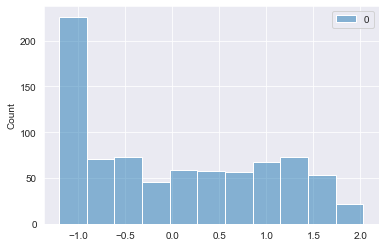

In [7]:
from sklearn.preprocessing import PowerTransformer

# Yeo-Johnson transformation of output
pt_out = PowerTransformer(standardize=True)
# extract target and convert to 1D array
y_xwOBA = marte_vs.xwOBA.to_numpy().reshape(-1, 1)
# transformation
trx_xwOBA = pt_out.fit_transform(y_xwOBA)
sns.histplot(trx_xwOBA)

## Transformations
### Dummies
A common mistake is to apply transformations to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set.

In [11]:
marte_vs_trx = pd.get_dummies(data=marte_vs, columns=['pitch_type', 'zone'])
marte_vs_trx = pd.get_dummies(data=marte_vs_trx, columns=['p_throws'], drop_first=True)
marte_vs_trx.head()

,xwOBA,woba_value,game_year,pitcher,release_speed,release_spin_rate,spin_axis,pfx_x,pfx_z,pfx_v,...,zone_5,zone_6,zone_7,zone_8,zone_9,zone_11,zone_12,zone_13,zone_14,p_throws_R
0,0.709,0.9,2022,596001,92.9,2303.0,211.0,-1.15,0.68,1.336001,...,1,0,0,0,0,0,0,0,0,1
1,0.262,0.0,2022,596001,92.6,2316.0,204.0,-1.05,0.80,1.320038,...,0,0,0,0,1,0,0,0,0,1
2,0.231,0.0,2022,596001,93.0,2245.0,219.0,-1.13,0.79,1.378768,...,0,0,0,1,0,0,0,0,0,1
3,0.117,0.0,2022,518397,93.3,2189.0,135.0,1.19,0.28,1.222497,...,0,0,0,1,0,0,0,0,0,0
4,0.438,0.0,2022,502171,94.1,2126.0,221.0,-1.34,0.45,1.413542,...,0,0,0,0,0,0,0,0,0,1


### Feature and output transformations

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X = marte_vs_trx.drop(columns=['xwOBA', 'game_year', 'pitcher'])  # remove response var and extra features
y = marte_vs.xwOBA
# split data into training and testing sets

X = sm.add_constant(X)   # only needed for sm (not smf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1642)

print('Train set shape\n', X_train.shape, y_train.shape)
print('Test set shape\n', X_test.shape, y_test.shape)
print('---')

# transform numerical data
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

num_feats = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pfx_x', 'pfx_z']
# used for positive values
pt = PowerTransformer()
# get a transformed series of numerical features
X_train_trx = pt.fit_transform(X_train[num_feats])
# overwrite raw numerical data
X_train[num_feats] = X_train_trx

# transform the test set with the trained lambdas
X_test_trx = pt.transform(X_test[num_feats])
# overwrite raw numerical dataframe
X_test[num_feats] = X_test_trx
############################
# # normalize output
mms = MinMaxScaler().fit(y_train.to_numpy().reshape(-1, 1))
y_train_trx = pd.Series(map(lambda x: x[0], mms.transform(y_train.to_numpy().reshape(-1, 1))), index=y_train.index)
# normalize on the test output, converted to a pandas.Series with the original indicies
y_test_trx = pd.Series(map(lambda x: x[0], mms.transform(y_test.to_numpy().reshape(-1, 1))), index=y_test.index)

# drop woba_value from feature after use in normalizing response
X_train.drop(columns=['woba_value'], inplace=True)
X_test.drop(columns=['woba_value'], inplace=True)

print('Train trx set shape\n', X_train_trx.shape, y_train_trx.shape)
print('Test trx set shape\n', X_test_trx.shape, y_test_trx.shape)
print('---')

## Modeling
### Naive Model
*Note: did not transform the output for the naive model.

In [ ]:
# Marte's xwOBA for last 4 seasons ('19-'22) == .348
from sklearn.metrics import *

print(y.mean())
y_same_xwOBA = pd.Series(.348, index=range(0, y_train.size))
# if squared is false then rmse
naive_rmse = mean_squared_error(y_true=y_train, y_pred=y_same_xwOBA, squared=False)
print(f"naive mse: {naive_rmse}")

naive_r2 = r2_score(y_true=y_train, y_pred=y_same_xwOBA)
print(f"naive r2 score: {naive_r2}")

### NN
#### Model 1

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Dropout, BatchNormalization


# normalizer = preprocessing.Normalization()
# normalizer.adapt(np.array(train_features))
X_1 = X_train.release_spin_rate
X_1_test = X_test.release_spin_rate
number_of_inputs = 1  # number of features
model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

print("Fit model on training data")
history = model.fit(
    X_1,
    y_train_trx,
    batch_size=42,
    epochs=16,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_1_test, y_test_trx),
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_1_test, y_test_trx, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_1_test.iloc[:42,])
print("predictions shape:", predictions.shape)

#### NN2 -- Higher Fidelity Model

In [ ]:
X_feats2 = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_R']
X_full = X_train[X_feats2]
X_full_test = X_test[X_feats2]
number_of_inputs = X_full.shape[1]  # number of features
model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=32,
    epochs=16,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

In [ ]:
from tensorflow.keras import regularizers

X_feats3 = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']
X_full = X_train[X_feats3]
X_full_test = X_test[X_feats3]
number_of_inputs = X_full.shape[1]  # number of features
model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(), bias_regularizer=regularizers.l1()),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=32,
    epochs=4000,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

#### Hyper sweep

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_and_compile_model():
    # create model
    model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                              layers.Dense(16, activation='relu'),
                              layers.Dense(1, activation='linear') ]) # output layer for regression

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)

# define the grid search parameters
batch_size = [8, 16, 32, 64, 128]
epochs = [10, 50, 250, 1250]

param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

grid_result = grid.fit(X_full, y_train_trx)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("train accuracy %f for: %r" % (mean, param))

In [ ]:
def create_and_compile_model(num_neurons, num_layers):
    # create model
    model = keras.Sequential()
    model.add(Dense(num_neurons, input_dim=number_of_inputs, activation='relu'))

    if num_layers > 0:

        while num_layers > 0:
            model.add(Dense(num_neurons, activation='relu'))
            num_layers=num_layers-1


    model.add(Dense(1, activation='linear')) # output layer for regression

    # Compile model
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

    print(model.summary())
    print('--')

    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)

# define the grid search parameters
num_neurons_grid = [4, 8, 16]
num_layers_grid = [1, 2, 3, 4]

param_grid = dict(num_neurons=num_neurons_grid, num_layers=num_layers_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

grid_result = grid.fit(X_full, y_train_trx)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("train accuracy %f for: %r" % (mean, param))

#### Combining Sweep
layers = 4
neurons = 8
batch_size = 8
epochs = 10

In [ ]:
model = keras.Sequential([layers.Dense(8, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(8, activation='relu'),
                          layers.Dense(8, activation='relu'),
                          layers.Dense(8, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=8,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

In [ ]:
factor = 0.01
model = keras.Sequential([layers.Dense(8, activation='relu', input_dim=number_of_inputs, kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=8,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

TW NN

In [ ]:
# Define the loss plot
def plot_loss(history, num_neurons):
  plt.plot(history.history['mse'], label='mse')
  plt.plot(history.history['val_mse'], label='val_mse')
  # plt.ylim([0, y_lim])
  plt.xlabel('Epoch')
  plt.ylabel('mse')
  plt.legend()
  plt.title(f"{num_neurons} neurons")

  plt.grid(True)
  plt.show()
  

import numpy as np
import tensorflow as tf
from   tensorflow import keras
from   tensorflow.keras import layers, regularizers
from   tensorflow.keras.layers.experimental import preprocessing
import matplotlib
import matplotlib.pyplot as plt
from   tensorflow.keras.optimizers import Adam

#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

number_of_inputs= X_train.shape[1]
print(f"# of inputs = {number_of_inputs}")

num_neurons = 3

# create model
model = keras.Sequential([normalizer,
                          layers.Dense(num_neurons, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(num_neurons, activation='relu'),
                          layers.Dense(1, activation='linear') ])  
  
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics='mse')

history = model.fit(X_train, 
                    y_train, 
                    batch_size=32,
                    epochs=100,
                    validation_split = 0.2)  # Calculate validation results on 20% of the training data
                  
# Isolate and plot training curves 
hist = pd.DataFrame(history.history)
plot_loss(history, num_neurons)

# calculate metrics ---------------
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# train
y_pred = model.predict(X_train)
print(f"MAE Train = {mean_absolute_error(y_train, y_pred)}")
print(f"MSE Train = { mean_squared_error(y_train, y_pred)}")
print(f"R2  = {                 r2_score(y_train, y_pred)}")
print(f"")

# holdout
y_pred = model.predict(X_test)
print(f"MAE Test = {mean_absolute_error(y_test, y_pred)}")
print(f"MSE Test = { mean_squared_error(y_test, y_pred)}")
print(f"R2  = {                r2_score(y_test, y_pred)}")

TW NN neurons sweep

In [ ]:
# Define the loss plot
def plot_loss(history):
  plt.plot(history.history['mse'], label='mse')
  plt.plot(history.history['val_mse'], label='val_mse')
  # plt.ylim([0, y_lim])
  plt.xlabel('Epoch')
  plt.ylabel('mse')
  plt.legend()
  plt.title(f"{num_neurons} neurons")

  plt.grid(True)
  plt.show()


from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization

#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

number_of_inputs = X_train.shape[1]

# sweep neurons
mse_list = []
val_mse_list = []

neurons_to_try = [1, 2, 3, 5, 7, 10, 15]

for num_neurons in neurons_to_try:

  #---- pasted in model
  model = keras.Sequential([normalizer,
                            layers.Dense(num_neurons, activation = 'relu', input_dim = number_of_inputs),
                            layers.Dense(num_neurons, activation = 'relu'),
                            layers.Dense(1, activation = 'linear') ])
    
  model.compile(loss='mse',
                optimizer = tf.keras.optimizers.Adam(0.001),
                metrics = 'mse')

  history = model.fit(X_train, y_train, 
                      epochs = 100,
                      batch_size = 32,
                      validation_split = 0.2)  # Calculate validation results on 20% of the training data
                    
  # Isolate the metric for each epoch.
  hist = pd.DataFrame(history.history)

  #---- end model paste

  # record metrics

  current_mse = hist['mse']
  current_mse = current_mse[len(current_mse)-1]  # last element is the final value
  mse_list.append(current_mse)  

  current_val_mse = hist['val_mse']
  current_val_mse = current_val_mse[len(current_val_mse)-1] #  last element is the final value
  val_mse_list.append(current_val_mse)

  plot_loss(history)

  # calculate metrics ---------------
  from sklearn.metrics import mean_absolute_error
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import r2_score

  # train
  y_pred = model.predict(X_train)
  print(f"MAE Train = {mean_absolute_error(y_train, y_pred)}")
  print(f"MSE Train = { mean_squared_error(y_train, y_pred)}")
  print(f"R2  = {                 r2_score(y_train, y_pred)}")
  print(f"")

  # holdout
  y_pred = model.predict(X_test)
  print(f"MAE Test = {mean_absolute_error(y_test, y_pred)}")
  print(f"MSE Test = { mean_squared_error(y_test, y_pred)}")
  print(f"R2  = {                r2_score(y_test, y_pred)}")

#plot results of sweep
plt.plot(neurons_to_try, mse_list, label='MSE')
plt.plot(neurons_to_try, val_mse_list, label='Validation MSE')

# plt.ylim([1,y_lim])
plt.xlabel('Neurons')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()